# Train Spanish model

* train and test sets are originally in Spanish
* LSTM gate unit

In [1]:
import gc
import json
import os
import random
import re
import time
from tqdm import tqdm

import keras
from keras.activations import tanh as Tanh
from keras.layers import Activation, Add, Dense, Embedding, Masking
from keras.layers import Input, SimpleRNN, LSTM, GRU
from keras.models import Model, load_model
from keras import regularizers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.utils import to_categorical 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import nltk
import numpy as np
import tensorflow as tf
import string, unicodedata
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

keras.backend.set_epsilon(1e-16)
keras.__version__
nltk.download('punkt')
nltk.download('wordnet')

np.random.seed(42)
random.seed(12345)
tf.set_random_seed(1234)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
keras.backend.get_session().run(tf.global_variables_initializer())

Using TensorFlow backend.


In [2]:
# DATASET PATHS
fasttext_enbeddings = "../../data/embeddings/fasttext/multi/wiki.multi.es.vec"
TRAIN_SENTENCES = "../../data/semeval/es/es-train-sentences.txt"
TRAIN_LABELS = "../../data/semeval/es/es-train-labels.txt"
TEST_SENTENCES = "../../data/semeval/es/es-test-sentences.txt"
TEST_LABELS = "../../data/semeval/es/es-test-labels.txt"

for link_ in [fasttext_enbeddings, TRAIN_SENTENCES, TRAIN_LABELS, TEST_SENTENCES, TEST_LABELS]:
    if not os.path.isfile(link_):
        print(f"`{link_}` NOT FOUND!")

In [3]:
# READ DATASET FUNCTIONS
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def preprocess_text(text):
    text = denoise_text(text)
    text = replace_contractions(text)
    return text

def split_into_words(text):
    return nltk.word_tokenize(text)

""" WORD LEVEL - NORMALIZATION """

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word, comma=".")
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('spanish'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer("spanish")
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
#     words = remove_stopwords(words)
    words = stem_words(words)
    return words

def read_labels(file_path):
    with open(file_path, "r") as labs_f:
        labels = [float(l.strip('\n')) for l in labs_f]
    return labels

def to_categorical_fractions(labels):
    # deal with fractional annotations in labels
    categories_num = to_categorical(labels).shape[1]
    results = []
    for lab in labels:
        major_label = int(lab)
        minor_label = major_label + 1
        minor_weight = lab - major_label
        major_weight = 1 - minor_weight
        cur_result = np.zeros(categories_num)
        cur_result[major_label] = major_weight
        if minor_weight > 0:
            cur_result[minor_label] = minor_weight
        results.append(cur_result)
    return np.array(results)

def read_linear_dataset(dataset_path):
    # return array of sentense pairs and vocabulary
    with open(dataset_path, "r") as ds_f:
        result = [[],[]]
        for line in ds_f:
            cur_line = line.split("\t")
            assert len(cur_line) == 2, f"error in cur_line (len {len(cur_line)}): {cur_line}"
            sent1 = cur_line[0].strip(" ")
            sent1 = preprocess_text(sent1)
            sent1 = split_into_words(sent1)
            sent1 = normalize(sent1)
            result[0].append(sent1)
            sent2 = preprocess_text(cur_line[1].strip("\n").strip(" "))
            sent2 = split_into_words(sent2)
            sent2 = normalize(sent2)
            result[1].append(sent2)
    return result

def get_embeddings(embeddings_path, words_num=None):
    # adapted to FastText embeddings
    with open(embeddings_path, "r") as emb_f:
        word2vec = {}
        for i, line in enumerate(emb_f):
            line = line.strip("\n").split(" ")
            if i == 0:
                total_word_num = int(line[0])
                words_num = words_num if total_word_num > words_num else total_word_num
                continue
            if line[0] in word2vec:
                print(line[0] + " is in vocab!. Vocab len: " + str(len(word2vec)))
            word2vec[line[0]] = np.asarray(line[1:], dtype='float32')
            if i == words_num:
                break
    return word2vec


def minimize_embeddings(data, principal_comp_fraction=0.85):
    """
    1. Prepare data for PCA
    2. PCA transformation
    3. Normalize features for training
    Note: first sampleshould be zeros
    """
    first_row = data[0]
    data = np.array(data[1:])
    data = StandardScaler().fit_transform(data)
    pca = PCA(principal_comp_fraction)
    data = pca.fit_transform(data)
    data = MaxAbsScaler().fit_transform(data)
    feats_num = data.shape[1]
    return np.vstack((first_row[:feats_num], data))

### READ DATASET

In [4]:
MAX_SEQUENCE_LENGTH = 100
VALIDATION_SPLIT = 0.25
EMBEDDING_DIM = 300
voc_words_num = 200000

# Spanish corpus was shuffled before splitting into train and test sets

# read embeddings -> dict(word : vector)
embeddings_index = get_embeddings(fasttext_enbeddings, words_num=voc_words_num)
# read labels
train_labels = read_labels(TRAIN_LABELS)
test_labels = read_labels(TEST_LABELS)
test_labels = test_labels[:350]
split_indx = int((1 - VALIDATION_SPLIT) * len(train_labels))


train_labels = to_categorical_fractions(train_labels)
val_labels = train_labels[split_indx:, :]
train_labels = train_labels[:split_indx, :]
test_labels = to_categorical_fractions(test_labels)
print(f"train_labels - shape: {train_labels.shape}, type {type(train_labels)}")
print(f"test_labels - shape: {test_labels.shape}, type {type(test_labels)}")
print(f"val_labels - shape: {val_labels.shape}, type {type(val_labels)}")
print(f"embeddings_index - type {type(embeddings_index)} - length {len(embeddings_index)}")
print(f"train_label example - {train_labels[2]}")
print(f"test_label example - {test_labels[2]}")
print(f"val_labels example - {val_labels[2]}")

# read dataset -> list(sentence_str1, sentence_str2)
train_dataset = read_linear_dataset(TRAIN_SENTENCES)
test_dataset = read_linear_dataset(TEST_SENTENCES)
test_dataset = [test_dataset[0][:350], test_dataset[1][:350]]

print(f"train_dataset - type: {type(train_dataset)}, len: {len(train_dataset)}")
print(f"test_dataset - type: {type(test_dataset)}, len: {len(test_dataset)}")
print(f"\ntrain_dataset - 5 first sentence pair lengths: ", end="")
print([(len(train_dataset[0][i]), len(train_dataset[1][i])) for i in range(5)])
print(f"test_dataset - 5 first sentence pair lengths: ", end="")
print([(len(test_dataset[0][i]), len(test_dataset[1][i])) for i in range(5)])

print("\n- train_dataset example pair -")
print(train_dataset[0][0])
print(train_dataset[1][0])
print("- test_dataset example pair -")
print(test_dataset[0][8])
print(test_dataset[1][8])

tokenizer = Tokenizer(filters="", lower=False, split=' ')
tokenizer.fit_on_texts(list(embeddings_index.keys()))

sequences_1 = tokenizer.texts_to_sequences(train_dataset[0])
sequences_2 = tokenizer.texts_to_sequences(train_dataset[1])
test_sequences_1 = tokenizer.texts_to_sequences(test_dataset[0])
test_sequences_2 = tokenizer.texts_to_sequences(test_dataset[1])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(list(word_index.items())[:10])

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')

assert len(data_1) == len(data_2)
assert len(test_data_1) == len(test_data_2)

data = [data_1[:split_indx], data_2[:split_indx]]
val_data = [data_1[split_indx:], data_2[split_indx:]]
test_data = [test_data_1, test_data_2]
print(f"Shapes of train data tensors: {data[0].shape}, {data[0].shape}")
print(f"Shapes of test data tensors: {test_data[0].shape}, {test_data[0].shape}")
print(f"Shapes of validation data tensors: {val_data[0].shape}, {val_data[0].shape}")
print(f"Shape of train label tensor: {train_labels.shape}")
print(f"Shape of test label tensor: {test_labels.shape}")
print(f"Shape of val label tensor: {val_labels.shape}")

print(data[0][0])
print(data[1][0])

train_labels - shape: (1083, 6), type <class 'numpy.ndarray'>
test_labels - shape: (350, 6), type <class 'numpy.ndarray'>
val_labels - shape: (361, 6), type <class 'numpy.ndarray'>
embeddings_index - type <class 'dict'> - length 200000
train_label example - [0.5 0.5 0.  0.  0.  0. ]
test_label example - [0.  0.  0.  0.2 0.8 0. ]
val_labels example - [0. 1. 0. 0. 0. 0.]
train_dataset - type: <class 'list'>, len: 2
test_dataset - type: <class 'list'>, len: 2

train_dataset - 5 first sentence pair lengths: [(10, 10), (36, 51), (22, 19), (20, 12), (42, 51)]
test_dataset - 5 first sentence pair lengths: [(45, 31), (35, 17), (8, 10), (40, 30), (25, 45)]

- train_dataset example pair -
['el', 'part', 'de', 'voleibol', 'esta', 'en', 'curs', 'entre', 'las', 'dam']
['mujer', 'particip', 'en', 'las', 'final', 'de', 'la', 'competent', 'de', 'tenis']
- test_dataset example pair -
['un', 'hombr', 'muestr', 'algun', 'rop', 'mientr', 'usa', 'zapat', 'azul', '.']
['un', 'hombr', 'y', 'una', 'muj', 'est

In [5]:
# embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(200001, 300)


In [6]:
embedding_matrix_pca = minimize_embeddings(embedding_matrix, principal_comp_fraction=50)
print(embedding_matrix_pca.shape)

(200001, 50)


In [7]:
embedding_matrix = embedding_matrix_pca
EMBEDDING_DIM = embedding_matrix.shape[1]
del embedding_matrix_pca
print(embedding_matrix.shape)

(200001, 50)


## Model

In [8]:
# Measure
def pearson_r(y_true, y_pred):
    # https://github.com/WenYanger/Keras_Metrics/blob/master/PearsonCorr.py
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

# Model
def one_layer_simple_rnn_model(rnn_gate):

    embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                                  input_length=MAX_SEQUENCE_LENGTH, trainable=False, name="embedding_layer")
    masking_layer = Masking(mask_value=0, name="masking_layer")
    no_activation_dense = Dense(EMBEDDING_DIM, activation=None, name="no_activation_dense")

    x1 = Input(shape=(None,), dtype='int32', name="x1")
    masked_1 = masking_layer(x1)
    embedded_sequences_1 = embedding_layer(masked_1)
    h11 = rnn_gate(embedded_sequences_1)

    x2 = Input(shape=(None,), dtype='int32', name="x2")
    masked_2 = masking_layer(x2)
    embedded_sequences_2 = embedding_layer(masked_2)
    h21 = rnn_gate(embedded_sequences_2)
    
    S11 = no_activation_dense(h11)
    S12 = no_activation_dense(h21)
    s1 = Add(name="concat_layer")([S11, S12])
    s1 = Activation('tanh', name="output_activation")(s1)
    s2 = Dense(6, activation='softmax', name="output_layer")(s1)

    model = Model(inputs=[x1, x2], outputs=s2)
    return model



## Experiments

### Training LSTM network (LSTM has shown slightly better results than GRU)

In [9]:
# setup
BASE_DIR = "es-model/6-es-model"

if not os.path.isdir(f"{BASE_DIR}/weights"):
    os.makedirs(f"{BASE_DIR}/weights")

params = {
    "output_vector_size": 50,
    "batch_size": 128,
    "epochs_num": 250,
    "learning_rate": 0.05,
    "momentum": 0,
    "decay": 0.001,
    "regularization": 0.001
}

with open(f"{BASE_DIR}/model_params.json", 'w') as outfile:
    json.dump(params, outfile, indent=4)

optimizer = keras.optimizers.SGD(lr=params["learning_rate"],
                                 momentum=params["momentum"],
                                 decay=params["decay"],
                                 nesterov=False)
lstm_gate = LSTM(params["output_vector_size"], activation='tanh', use_bias=True,
                 activity_regularizer=regularizers.l2(params["regularization"]))

# loggers
ckpt_file = f"{BASE_DIR}" + "/weights/weights.epoch_{epoch:02d}.valloss_{val_loss:.2f}.valpearson_{val_pearson_r:.02f}.hdf5"
checkpoint_logger = keras.callbacks.ModelCheckpoint(
    ckpt_file, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False,
    mode='auto', period=1)
tensorboard_logger = keras.callbacks.TensorBoard(
    log_dir=f"{BASE_DIR}/logs", write_graph=True, write_images=True, update_freq="epoch")
csv_logger = keras.callbacks.CSVLogger(f"{BASE_DIR}/training-log.csv")

# create model
model = one_layer_simple_rnn_model(lstm_gate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[pearson_r])

# before training evaluation
print("Initial evaluation")
zero_loss, zero_measure = model.evaluate(x=data, y=train_labels, batch_size=params["batch_size"], verbose=1)
val_zero_loss, val_zero_measure = model.evaluate(x=val_data, y=val_labels, batch_size=params["batch_size"], verbose=1)
test_zero_loss, test_zero_measure = model.evaluate(x=test_data, y=test_labels, batch_size=params["batch_size"], verbose=1)

print(f"initial:\nloss: {zero_loss}, val: {val_zero_loss}, test: {test_zero_loss}",
      f"\nmeasure: {zero_measure}, val: {val_zero_measure}, test: {test_zero_measure}")
with open(f"{BASE_DIR}/zero_epoch_loss_measure.txt", "w") as out_f:
    out_f.write(f"loss\ntrain: {zero_loss}\nval: {val_zero_loss}\ntest: {test_zero_loss}")
    out_f.write(f"\n\nmeasure\ntrain: {zero_measure}\nval: {val_zero_measure}\ntest {test_zero_measure}")

# train
start_time = time.time()
print(f"\n- Training LSTM Spanish model")
model_history = model.fit(data, train_labels, validation_data=(val_data, val_labels),
                          epochs=params["epochs_num"], verbose=2, batch_size=params["batch_size"],
                          callbacks=[checkpoint_logger, csv_logger])

print("max val_pearson_r - {} at {}".format(
    np.max(model_history.history['val_pearson_r']),
    np.argmax(model_history.history['val_pearson_r'])+1))
    
elapsed_time = int((time.time() - start_time) / 60)

# save json dumps of experiment
OUT_PATH = f"{BASE_DIR}/es-model_histories-for-plots.json"
with open(OUT_PATH, 'w') as outfile:
    json.dump(model_history.history, outfile, indent=4)

print(f"time spent - total {elapsed_time} min")

Initial evaluation
350/350 [==============================] - 0s 462us/step
initial:
loss: 1.8723347849682979, val: 1.8745060789287915, test: 1.8687878956113544 
measure: -0.1488939177791828, val: -0.1629451471600176, test: -0.1518971937894821

- Training LSTM Spanish model
Train on 1083 samples, validate on 361 samples
Epoch 1/250
 - 2s - loss: 1.7817 - pearson_r: 0.1577 - val_loss: 1.7482 - val_pearson_r: 0.2149
Epoch 2/250
 - 2s - loss: 1.7297 - pearson_r: 0.2429 - val_loss: 1.7351 - val_pearson_r: 0.2226
Epoch 3/250
 - 2s - loss: 1.7196 - pearson_r: 0.2463 - val_loss: 1.7223 - val_pearson_r: 0.2341
Epoch 4/250
 - 2s - loss: 1.7150 - pearson_r: 0.2462 - val_loss: 1.7170 - val_pearson_r: 0.2366
Epoch 5/250
 - 2s - loss: 1.7106 - pearson_r: 0.2491 - val_loss: 1.7128 - val_pearson_r: 0.2393
Epoch 6/250
 - 2s - loss: 1.7075 - pearson_r: 0.2501 - val_loss: 1.7101 - val_pearson_r: 0.2410
Epoch 7/250
 - 2s - loss: 1.7067 - pearson_r: 0.2486 - val_loss: 1.7095 - val_pearson_r: 0.2396
Epoch 

 - 2s - loss: 1.6827 - pearson_r: 0.2706 - val_loss: 1.6971 - val_pearson_r: 0.2491
Epoch 82/250
 - 2s - loss: 1.6828 - pearson_r: 0.2698 - val_loss: 1.6957 - val_pearson_r: 0.2503
Epoch 83/250
 - 2s - loss: 1.6819 - pearson_r: 0.2711 - val_loss: 1.6955 - val_pearson_r: 0.2515
Epoch 84/250
 - 2s - loss: 1.6827 - pearson_r: 0.2712 - val_loss: 1.6945 - val_pearson_r: 0.2523
Epoch 85/250
 - 2s - loss: 1.6818 - pearson_r: 0.2722 - val_loss: 1.6957 - val_pearson_r: 0.2508
Epoch 86/250
 - 2s - loss: 1.6817 - pearson_r: 0.2723 - val_loss: 1.6956 - val_pearson_r: 0.2510
Epoch 87/250
 - 2s - loss: 1.6824 - pearson_r: 0.2724 - val_loss: 1.6946 - val_pearson_r: 0.2521
Epoch 88/250
 - 2s - loss: 1.6814 - pearson_r: 0.2721 - val_loss: 1.6952 - val_pearson_r: 0.2516
Epoch 89/250
 - 2s - loss: 1.6814 - pearson_r: 0.2719 - val_loss: 1.6943 - val_pearson_r: 0.2526
Epoch 90/250
 - 2s - loss: 1.6814 - pearson_r: 0.2723 - val_loss: 1.6957 - val_pearson_r: 0.2511
Epoch 91/250
 - 2s - loss: 1.6810 - pearson

Epoch 165/250
 - 2s - loss: 1.6686 - pearson_r: 0.2880 - val_loss: 1.6895 - val_pearson_r: 0.2571
Epoch 166/250
 - 2s - loss: 1.6684 - pearson_r: 0.2877 - val_loss: 1.6884 - val_pearson_r: 0.2584
Epoch 167/250
 - 2s - loss: 1.6675 - pearson_r: 0.2896 - val_loss: 1.6880 - val_pearson_r: 0.2589
Epoch 168/250
 - 2s - loss: 1.6683 - pearson_r: 0.2883 - val_loss: 1.6879 - val_pearson_r: 0.2592
Epoch 169/250
 - 2s - loss: 1.6679 - pearson_r: 0.2896 - val_loss: 1.6911 - val_pearson_r: 0.2553
Epoch 170/250
 - 2s - loss: 1.6682 - pearson_r: 0.2885 - val_loss: 1.6880 - val_pearson_r: 0.2589
Epoch 171/250
 - 2s - loss: 1.6672 - pearson_r: 0.2892 - val_loss: 1.6898 - val_pearson_r: 0.2571
Epoch 172/250
 - 2s - loss: 1.6675 - pearson_r: 0.2890 - val_loss: 1.6894 - val_pearson_r: 0.2574
Epoch 173/250
 - 2s - loss: 1.6673 - pearson_r: 0.2892 - val_loss: 1.6877 - val_pearson_r: 0.2595
Epoch 174/250
 - 2s - loss: 1.6666 - pearson_r: 0.2897 - val_loss: 1.6893 - val_pearson_r: 0.2576
Epoch 175/250
 - 2s 

Epoch 249/250
 - 2s - loss: 1.6568 - pearson_r: 0.3019 - val_loss: 1.6843 - val_pearson_r: 0.2625
Epoch 250/250
 - 2s - loss: 1.6564 - pearson_r: 0.3008 - val_loss: 1.6889 - val_pearson_r: 0.2586
max val_pearson_r - 0.2669370906670008 at 240
time spent - total 7 min


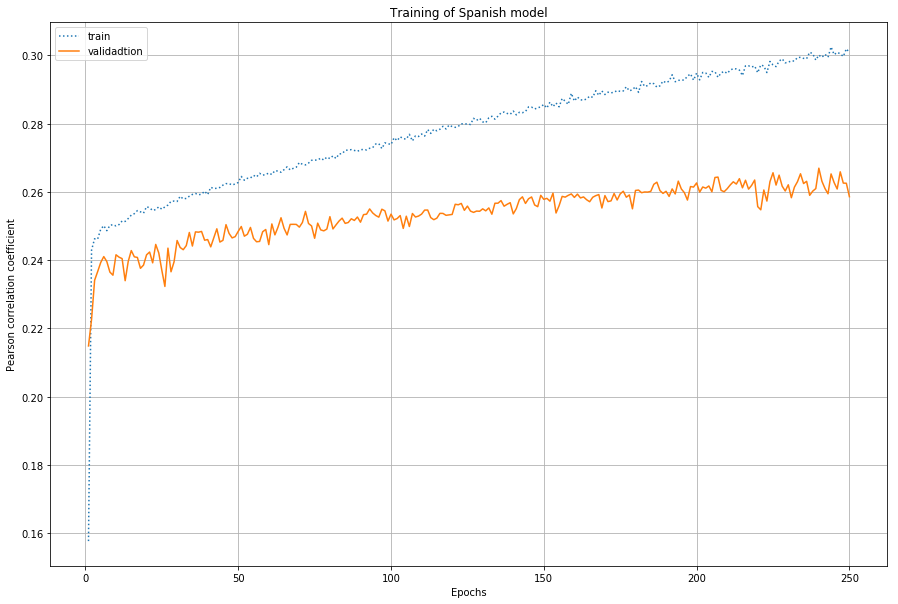

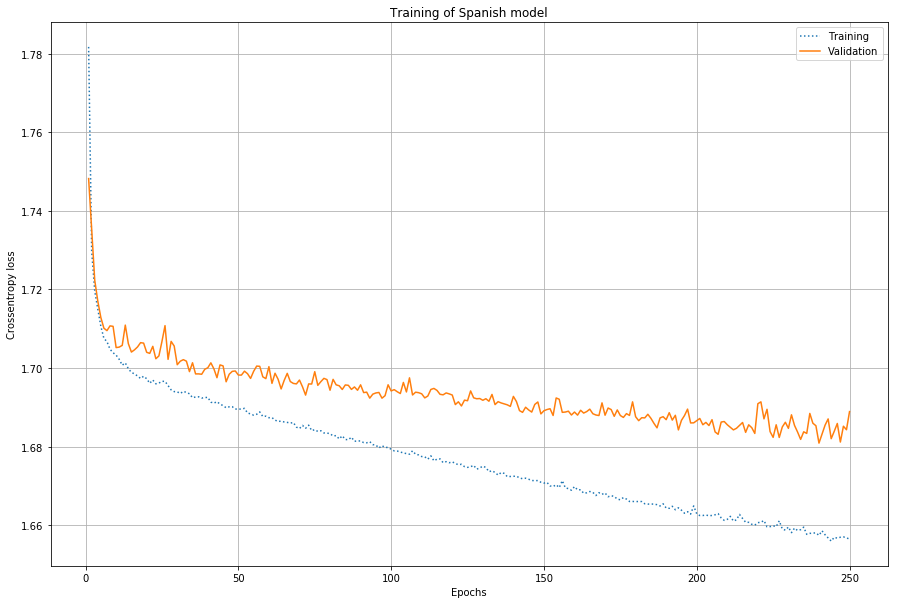

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

epochs = list(range(len(model_history.history['pearson_r'])))
acc = model_history.history['pearson_r']
val_acc = model_history.history['val_pearson_r']
plt.plot([e+1 for e in epochs], acc, linestyle=':', label=f'train')
plt.plot([e+1 for e in epochs], val_acc, label=f'validadtion')
plt.xlabel("Epochs")
plt.ylabel("Pearson correlation coefficient")
plt.title("Training of Spanish model")
plt.legend()
plt.grid(b=True)
plt.savefig(f"{BASE_DIR}/es-model_training-output_pearson.png", bbox_inches='tight')

plt.figure()
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.plot([e+1 for e in epochs], loss, linestyle=':', label=f'Training')
plt.plot([e+1 for e in epochs], val_loss, label=f'Validation')
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.title('Training of Spanish model')
plt.legend()
plt.grid(b=True)
plt.savefig(f"{BASE_DIR}/es-model_training-output_loss.png", bbox_inches='tight')
plt.show()


### Test the best model

In [11]:
best_model_path = f"{BASE_DIR}/weights/weights.epoch_240.valloss_1.68.valpearson_0.27.hdf5"
best_model = load_model(best_model_path, custom_objects={'pearson_r': pearson_r})
best_model.evaluate(x=val_data, y=val_labels, batch_size=5, verbose=1)

361/361 [==============================] - 4s 11ms/step


[1.6681991049457454, 0.271001688362076]

In [12]:
K.clear_session()
gc.collect()
del best_model

In [13]:
best_model = load_model(best_model_path, custom_objects={'pearson_r': pearson_r})
best_model.evaluate(x=test_data, y=test_labels, batch_size=5, verbose=1)

350/350 [==============================] - 4s 10ms/step


[1.684213559968131, 0.2526943923905492]